# Reinforcement Learning Tutorial
presented by Taylor Childers (Argonne)

Content and examples based on this blog post from:
Adam Kleczewski (PhD. in Physics)
https://adamklecz.wordpress.com/2017/10/30/tic-tac-tensorflow/

In the tutorial, we build a Tic Tac Toe gaming environment with the games rules in which our players can make moves and learn the best methods for optimizing the result, i.e. winning the game.

# Deep Q-learning
https://en.wikipedia.org/wiki/Q-learning

Reinforment Learning uses a Q-learning method, which aims to find a state-action value function

`Q(s,a)` 

that can characterize the value of taking action `a` given state `s`. 

In Deep Q-Learning this function is represented with a neural network. It can be a simple dense neural network, as we will use here, or  more complicated using Convolutional NNs like those used in DeepMind.

In the following examples we also use a simpler state-only value function `V(s)` which only takes the current state of the game and calculates the reward for that state. 

# Learning to Play Tic Tac Toe

We will use Tic Tac Toe as an example to explore Reinforment Learning.

We are looking to train an ML model that can predict the value of making a move in our Tic Tac Toe board. 

Our model will be simple with one hidden layer. Our input will encode the current state of the board including who's turn it is. This is arranged as a flat input with the following binary features: location of Xs, location of Os, empty locations, and one value to represent whose turn it is.

The model outputs a prediction for the maximum possible reward expected at the end of the game given the action inside the current board state.

![model_graph](https://adamklecz.files.wordpress.com/2017/10/null9.png)



In [1]:
# load up necessary modules
import numpy as np
import logging,copy,os
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipydis
# turn off all the deprecation warnings
tf.logging.set_verbosity(logging.ERROR)
# turn on eager execution
tf.enable_eager_execution()
tfe = tf.contrib.eager
print('Tensorflow Version: %s',tf.__version__)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Tensorflow Version: %s 1.13.1


In [66]:
# here is our model to be trained
class ValueModel(tf.keras.Model):
  def __init__(self, input_dim, hidden_dim = 100):
    super(ValueModel, self).__init__()
    # this is our dense hidden layer witha ReLU activiation that will encode most of our information
    self.hidden_layerA = tf.keras.layers.Dense(hidden_dim,'relu',input_shape=(input_dim,))
    # added an extra layer
    #self.hidden_layerB = tf.keras.layers.Dense(hidden_dim,'relu')
    # then we reduce to a single output with a tanh activation
    # we use tanh because -1 <= tanh(x) <= 1 and we will build a reward system based on a range -1 to 1
    self.output_layer = tf.keras.layers.Dense(1,'tanh')

  def call(self,input):
    # this is the function used to actually evaluate our model on input data
    x = self.hidden_layerA(input)
    #x = self.hidden_layerB(x)
    x = self.output_layer(x)
    return x

# Building a Tic Tac Toe Board
We need to build our tic tac toe board. This will hold a representation of the board in a given state. 

We keep track of our board with two sub-boards; one for X and one for O. 

We also keep track of who's turn it is and a list of possible moves that remain. 

I've seen many different implementations of this representation so there is nothing special about this method. It's just important you have all the information you need to represent the state of the game.

In [3]:
class TicTacToeBoard:
  def __init__(self):
    # setup two boards
    # one to track location of X
    self.xs = np.zeros((3, 3))
    # one to track location of O
    self.os = np.zeros((3, 3))
    # keep list of legal moves, as moves are made, 
    # they are removed from this list
    self.legal_moves = set(range(9))
    # keep track of who's turn it is: True == X-turn, False == O-turn
    self.turn = True #np.random.choice([True,False])
  
  def push(self, move):
    # move as number from 0 - 8, calculate row/col
    row = int(move / 3)
    col = move % 3
    # make sure spot is vacant
    assert self.xs[row, col] == 0
    assert self.os[row, col] == 0
    
    # make sure move is legal
    assert move in self.legal_moves
    # remove move from legal moves
    self.legal_moves.remove(move)
    
    # place X or O based on turn
    if self.turn:
       self.xs[row, col] = 1
    else:
       self.os[row, col] = 1
    # change turn
    self.turn = not self.turn

  def result(self):
    # calculate if someone has won:
    # X wins
    if (self.xs.all(axis=0).any() or self.xs.all(axis=1).any() or 
        self.xs.diagonal().all() or np.rot90(self.xs).diagonal().all()):
      return 1.0
    # O wins
    elif (self.os.all(axis=0).any() or self.os.all(axis=1).any() or 
          self.os.diagonal().all() or np.rot90(self.os).diagonal().all()):
      return -1.0
    # stale mate
    elif (self.xs + self.os).sum() == 9:
      return 0.0
    # game not yet finished
    else:
      return None

  def copy(self):
    return copy.deepcopy(self)

# Building the Game Environment
Next we build an environment around the board. This environment will have a few helper methods to help manage the life-time of a game from start to finish. 

One helper method is the `make_feature_vector()` which creates the input vector to our machine learning model. This feature vector is simple a flat vector our our two boards, where no moves have been made, and who's turn it is.

The `play()` method takes a list of two players (or agents), and runs a game from start to finish and returns the result (`1`=X-wins,  `-1`=O-wins,  `0`=stalemate)

In [4]:
class TicTacToeEnv:
  def __init__(self):
    # environment includes a board
    self.board = TicTacToeBoard()
    # environment includes a feature vector
    # this is the input to our ML model
    self.feature_vector_size = 28

  def reset(self):
    # can reset the board
    self.board = TicTacToeBoard()

  def get_reward(self):
    # retrieve result of current board state
    return self.board.result()

  def make_move(self, move):
    # make a move on the board
    self.board.push(move)

  def make_random_move(self):
    # make a random move
    legal_moves = self.get_legal_moves()
    move = np.random.choice(legal_moves)
    self.make_move(move)

  def get_legal_moves(self):
    # return a list of the current legal moves available
    return list(self.board.legal_moves)

  def make_feature_vector(self, board):
    # build a feature vector from the current board
    fv_size = self.feature_vector_size
    # create empty feature vector
    fv = np.zeros((1, fv_size))
    # set X locations
    fv[0, :9] = board.xs.reshape(9)
    # set O locations
    fv[0, 9:18] = board.os.reshape(9)
    # set empty locations
    fv[0, 18:27] = ((board.xs + board.os).reshape(9) == 0)
    # set who's turn it is
    fv[0, -1] = float(board.turn)
    return fv

  def play(self, players, verbose=False):
    # players is a list of agents playing the game
    
    # calculate current reward
    reward = self.get_reward()
    
    # reward is None when game has not finished
    while reward is None:
      if verbose:
        self._print()
      # this simply rotates between players
      # if it was X's turn, it returns O's turn
      player = players[int(not self.board.turn)]
      # get a move from the agent
      move = player.get_move()
      # apply the move to the environment
      self.make_move(move)
      # recalculate the reward, while-loop repeats if not finished
      reward = self.get_reward()

    if verbose:
      self._print()
      if reward == 1:
        print("X won!")
      elif reward == -1:
        print("O won!")
      else:
        print("draw.")
    return reward
  
  def _print(self, board=None):
    # clear the disply
    ipydis.clear_output()
    # print the current board
    if board is None:
      board = self.board
    s = ''
    for i in range(3):
      s += ' '
      for j in range(3):
        if board.xs[i, j] == 1:
          s += 'X'
        elif board.os[i, j] == 1:
          s += 'O'
        else:
          s += ' '
        if j < 2:
          s += '|'
      s += '\n'
      if i < 2:
        s += '-------\n'
    print(s)

# Building Game Players: Agents
In reinforcement learning, agents are used to explore the environment and thereby train the model on best practices.

We'll start with a base agent on which we will build our players.


In [5]:
class AgentBase:
  def __init__(self, model, env):
    # keep a local copy of the model and environment
    self.model = model
    self.env = env
    
    # an episode is one move
    self.episode_count = 0
    
    # keep track of the number of wins/loss/draws
    self.x_wins = 0
    self.x_draws = 0
    self.x_losses = 0

    self.o_wins = 0
    self.o_draws = 0
    self.o_losses = 0
    
    # reset global step
    tf.train.get_or_create_global_step().assign(0)
    
    # for learning rate decay
    self.lr_init = 0.1
    self.decay = tfe.Variable(0.75)
    self.period = tfe.Variable(1.0e5)
    self.lrvar = tfe.Variable(self.lr_init)
  
  # to use LR decay, call this function in your train function
  def learning_rate_update(self):
    lr = self.lr_init * tf.math.pow(self.decay,tf.math.floordiv(tf.cast(self.episode_count,tf.float32),self.period))
    self.lrvar.assign(lr)
  
  # set learning rate decay variables
  def set_lr_init(self,value):
    self.lr_init = value
    self.lrvar.assign(value)
  def set_decay(self,value):
    self.decay.assign(value)
  def set_period(self,value):
    self.period.assign(value)

  def add_results(self,results):
    self.x_wins    = results[0]
    self.x_draws   = results[1]
    self.x_losses  = results[2]
    self.o_wins    = results[3]
    self.o_draws   = results[4]
    self.o_losses  = results[5]

  def increment_episode(self):
    self.episode_count += 1

  def get_move(self):
    # get a list of legal moves from the environment
    legal_moves = self.env.get_legal_moves()
    # compile a list of the resulting boards for all legal moves
    candidate_boards = []
    for move in legal_moves:
      candidate_board = self.env.board.copy()
      candidate_board.push(move)
      candidate_boards.append(candidate_board)
    
    # stack these possible outcomes into a batch
    feature_vectors = np.vstack(
       [self.env.make_feature_vector(board) for board in candidate_boards])
    
    # get the predicted rewards for each outcome
    values = self.model(feature_vectors)
    values = values.numpy()
    
    # loop over boards
    for idx, board in enumerate(candidate_boards):
      # get the result, 1=X-wins, -1=O-wins, 0=draw, None=not done
      result = board.result()
      if result is not None:
        # if there is a result, update the prediction for the board
        values[idx] = result
    
    # if current player is X, look for board with the max because 1 = X-wins
    if self.env.board.turn:
      move_idx = np.argmax(values)
    # if current player is O, look for board with the min because -1 = O-wins
    else:
      move_idx = np.argmin(values)
    # choose the move for the board with the best result
    move = legal_moves[move_idx]

    return move

# SimpleAgent

We build a SimpleAgent that trains the model in a manner similar to supervised learning methods.

![simple_agent](https://adamklecz.files.wordpress.com/2017/10/null1.png)

The agent starts with an empty board (`s_0`), and plays against itself, building up a list of intermediate game states (`s_i`), until the game ends (`s_T`) with the reward (`r_T`) being a win(`1`), loss(`-1`), or draw(`0`). During training, the model produces a predicted reward for each turn of the game, but the environment only provides a reward for the last move. Thus the loss for each `s_i` is calculated using the same final reward `r_T` for each board state in the game.

This is the most simplistic agent and follows what is called a 'greedy policy.'

Notice that the `train` function inserts a random move for `epsilon` fraction of the moves. This randomization ensures our model tries new strategies instead of only learning one.

In [6]:
class SimpleAgent(AgentBase):
  def __init__(self,model,env):
    super(SimpleAgent,self).__init__(model,env)
    
    # using learning rate decay variable from base class
    self.opt = tf.train.GradientDescentOptimizer(self.lrvar)
    #self.opt = tf.train.AdamOptimizer(self.lrvar)

  def loss(self,inputs,targets):
    # get predicted rewards for set of inputs
    results = self.model(inputs)
    # calculate the difference between the prediction and actual result
    loss = tf.reduce_mean(tf.abs(targets - results))
    return loss

  def grad(self,inputs,targets):
    # get loss for inputs and targets
    with tf.GradientTape() as tape: # <-- necesary for eager execution in TF
      loss_value = self.loss(inputs, targets)
    # return the gradients
    return tape.gradient(loss_value, self.model.trainable_variables)

  def train(self, epsilon):
    # reset board
    self.env.reset()
    
    # reward for current board state
    reward = None
    
    # call learning rate update for each episode played
    self.learning_rate_update()
    
    # list of board states for each turn, represented as input vectors
    feature_vectors = []
    
    # loop until reward is reached
    while reward is None:
      feature_vector = self.env.make_feature_vector(self.env.board)
      feature_vectors.append(feature_vector)
      
      # insert some random fluctuations to ensure stategy space is fully explored
      if np.random.random() < epsilon:
        self.env.make_random_move()
      # make the best move based on the current model
      else:
        move = self.get_move()
        self.env.make_move(move)
      
      # get reward from current board (1=X-wins,-1=O-wins,0=draw,None=not-finished)
      reward = self.env.get_reward()
    
    # create an input batch out of the games moves
    inputs = np.vstack(feature_vectors)
    # calculate the gradients based on the reward for these inputs
    grads = self.grad(inputs,reward)
    # apply gradients to model
    self.opt.apply_gradients(zip(grads, self.model.trainable_variables),
                             global_step=tf.train.get_or_create_global_step())
    
    # return reward
    return self.env.get_reward()

# Random Agent

The training of the model is done with our SimpleAgent playing both sides, but we also need a way to validate that our agent is learning good strategy. For this simple case of Tic Tac Toe we can simply use a RandomAgent as our validation. 

This agent choses a random move each time. While this is not very sophisticated, it is sufficient in this simple game.

In [7]:
class RandomAgent:
  def __init__(self, env, games = 100):
    self.env = env
    self.games = games

  def get_move(self):
    # get a list of the legal moves remaining
    legal_moves = self.env.get_legal_moves()
    # chose randomly from this list
    move = np.random.choice(legal_moves)
    return move

  def test(self, agent):
    # play 100 games with RandomAgent as X and the passed agent as O
    x_counter = Counter()
    for _ in range(self.games):
      agent.env.reset()
      reward = agent.env.play([agent, self])
      x_counter.update([reward])
    
    # now play 100 games with opposite players
    o_counter = Counter()
    for _ in range(self.games):
      agent.env.reset()
      reward = agent.env.play([self, agent])
      o_counter.update([reward])

    results = [x_counter[1], x_counter[0], x_counter[-1],
               o_counter[-1], o_counter[0], o_counter[1]]

    return results

# Training our SimpleAgent
Now we have all the tools to train our agent to play the Tic Tac Toe.

Here is a training function that runs for some number of 'episodes' (or games) and tests the model periodically against the random agent.

In [43]:
def train_agent(agent_class, # agent class to train
                episodes=100000, # number of episode to train
                test_frequency=1000,  # frequency of testing against RandomAgent
                model_hidden_layer_size=100, # number of features in hidden layer of model
                random_move_rate=0.2, # how often to insert random move during training
                plot=True, # plot data using pyplot
                show_plot=True, # show plot in real time
                skip_restore=False, # do not restore the model at start up
                model_fn=None, # provide a custom filename to load
                lr_init=0.1,
                lr_decay=0.75,
                lr_period=1.0e5): 
  
  # create our Environment which includes a board
  env = TicTacToeEnv()
  # create our Model, or our function Q(s,a)
  model = ValueModel(env.feature_vector_size, model_hidden_layer_size)
  
  # load model weights if a file exists
  print(f'training agent: {agent_class.__name__}')
  weight_fn = f'{agent_class.__name__}_agent.h5'
  if os.path.exists(weight_fn) and not skip_restore:
    # have to run model once to build the weights
    model(np.random.rand(1,env.feature_vector_size))
    if model_fn is not None:
      print(f'restoring file: {model_fn}')
      # load the weights
      model.load_weights(model_fn)
    else:
      print(f'restoring file: {weight_fn}')
      # load the weights
      model.load_weights(weight_fn)
  
  # create a simple and random agents
  agent = agent_class(model, env)
  # set learning rate parameters
  agent.set_lr_init(lr_init)
  agent.set_decay(lr_decay)
  agent.set_period(lr_period)
  # create the random agent for testing
  random_agent = RandomAgent(env)
  
  
  # ˇˇˇˇˇ this is for plotting only ˇˇˇˇˇ
  if plot:
    # keep a list of the win fraction of X and O
    x_wf = []
    o_wf = []
    
    # create a figure
    fig = plt.figure(figsize=(8, 6), dpi=80)
    # create a subplot in that faigure
    ax = fig.add_subplot(1, 1, 1)
    
    image_fn = f'{agent_class.__name__}_agent.png'
  # ^^^^^ this is for plotting only ^^^^^
  
  # loop for some number of game episodes
  while agent.episode_count < episodes:
    
    # every now and then test the agent against the random agent
    if agent.episode_count % test_frequency == 0:
      # run test of agent vs random agent
      results = random_agent.test(agent)
      
      # keep running sum of wins/losses/draws
      agent.add_results(results)
      
      # calculate win fractions
      x_win_fraction = results[0] / np.sum(results[0:3])
      o_win_fraction = results[3] / np.sum(results[3:6])
      
      # save model weights to a file
      model.save_weights(weight_fn)
      
      # ˇˇˇˇˇ this is for plotting only ˇˇˇˇˇ
      if plot:
        # keep history of win fractions
        x_wf.append(x_win_fraction)
        o_wf.append(o_win_fraction)
        if show_plot:
          # first clear the display of previous plot
          ipydis.clear_output()
        # set the x-axis limit range
        ax.set_xlim(0,int(agent.episode_count/test_frequency)+1)
        # clear all pre-existing data from axis
        ax.cla()
        # set x/y axis labels
        ax.set_xlabel('episodes (x%s)'%test_frequency)
        ax.set_ylabel('win fraction')
        # create the x-axis data
        xaxis = range(int(agent.episode_count/test_frequency)+1)
        # here we actually create the plot of X
        ax.plot(xaxis,x_wf,label="X")
        # plot Y
        ax.plot(xaxis,o_wf,label="O")
        # add the legend
        ax.legend()
        ax.set_title(f'{agent_class.__name__} with {model_hidden_layer_size} hidden features')
        if show_plot:
          # display the plot
          ipydis.display(fig)
        fig.savefig(image_fn)
      # ^^^^^ this is for plotting only ^^^^^
      
    # print the results
      print(f'{agent.episode_count:05d}: results = ' + '%24s' % results + f' x_win_fraction = {x_win_fraction:5.3f}  o_win_fraction = {o_win_fraction:5.3f} lr = ' + str(agent.lrvar.numpy()))
  
    else:
      # here we actually run the training of our agent.
      reward = agent.train(random_move_rate)
    
    # increment episode number
    agent.increment_episode()

  # save model weights to a file
  model.save_weights(weight_fn)

Now we can train our SimpleAgent class. I have had a lot of trouble getting this model to converge in a resonable time so I include an image here and a model file that can be loaded to play.

![SimpleAgentTraining](SimpleAgent_agent_300hidden.png)


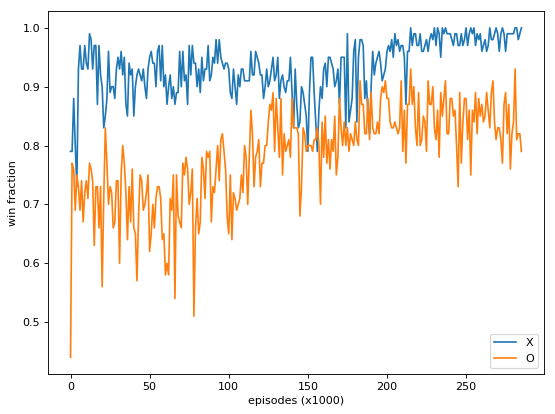

285000: results =   [100, 0, 0, 79, 20, 1] x_win_fraction = 1.000  o_win_fraction = 0.790 lr = 0.056250002


KeyboardInterrupt: 

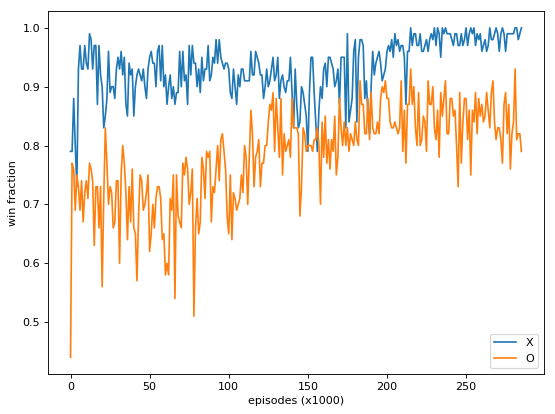

In [80]:
# with these settings I see X reach nearly 100% and O reach 85-90% in about 250k episodes
train_agent(SimpleAgent,1000000,model_hidden_layer_size=350,random_move_rate=0.2,skip_restore=True)

# Temporal difference learning

![td_agent](https://adamklecz.files.wordpress.com/2017/10/null2.png)

In the SImpleAgent, we trained on a full game with each step being labeled with the final result. However, ideally you would attribute some value to the each turn being taken. This is referred to as temporal difference learning which is another style of Q-Learning.

We will update our gradients using the following:

![tdagent_grads](https://s0.wp.com/latex.php?latex=%5Ctheta_%7Bt%2B1%7D+%3D+%5Ctheta_t+%2B+%5Cnabla+V%28s_t%29+%5Cdelta_t&bg=ffffff&fg=000000&s=0&zoom=2)

In the TDAgent, you can see that for each move in the game we calculate the difference between the current reward and the previous reward, `𝛿`. These are then multiplied by our model's gradients, `ΔV`, and added to the model's weights, `𝜽`, at each move.


In [9]:
class TDAgent(AgentBase):
  def __init__(self,model,env):
    super(TDAgent,self).__init__(model,env)
    
    self.opt = tf.train.GradientDescentOptimizer(self.lrvar)
    #self.opt = tf.train.AdamOptimizer(self.lrvar)
    
  def grad(self,inputs):
    # start gradient tape
    with tf.GradientTape() as tape:
      # calculate reward for inputs using model
      reward = self.model(inputs)
    # return the reward and the gradients based on this reward
    return reward,tape.gradient(reward, self.model.trainable_variables)

  def train(self, epsilon):
    # reset the board
    self.env.reset()
    
    # call learning rate update for each episode played
    self.learning_rate_update()
    
    # get the initial feature vector for empty board
    feature_vector = self.env.make_feature_vector(self.env.board)
    # get reward and model gradients for empty board
    previous_value,previous_grads = self.grad(feature_vector)
    
    # reward for empty board (= None)
    reward = self.env.get_reward()
    
    while reward is None:
      
      # make the first move, with some chance of a random move
      if np.random.random() < epsilon:
        self.env.make_random_move()
      else:
        move = self.get_move()
        self.env.make_move(move)
      
      # get the reward for new board configuration
      reward = self.env.get_reward()
      
      # get the new board representation
      feature_vector = self.env.make_feature_vector(self.env.board)
      
      # calculate the new reward and gradients
      if reward is None:
        value,grads = self.grad(feature_vector)
      else:
        value = reward
        _,grads = self.grad(feature_vector)
      
      # calculate the difference between this reward and the previous
      delta = value - previous_value
      # techincal detail
      delta = tf.reshape(delta,(1,))
      # need to weight all gradients by the delta
      new_grads = [-delta * g for g in previous_grads]
      
      # now apply the gradients
      self.opt.apply_gradients(zip(new_grads, self.model.trainable_variables),
                               global_step=tf.train.get_or_create_global_step())
      
      # current measurement becomes the previous before moving on
      previous_grads = grads
      previous_value = value
    
    # when game is over, return who won
    return self.env.get_reward()

Now we can train. I have not yet managed to get this model to converge... so let's move on.

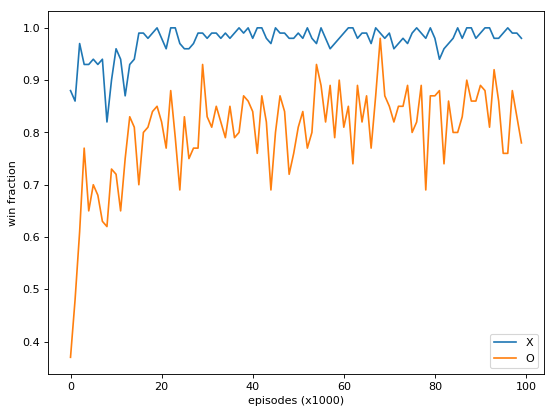

99000: results =    [98, 2, 0, 78, 18, 4] x_win_fraction = 0.980  o_win_fraction = 0.780 lr = 0.1


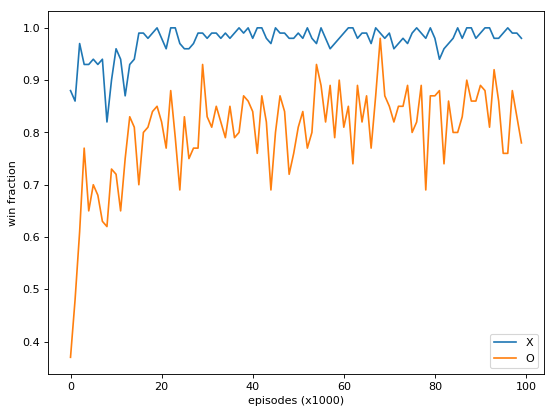

In [112]:
train_agent(TDAgent,skip_restore=True)

# Playing our trained agent

Now lets play our trained agent and see how well the RandomAgent was at characterizing what our Agent had learned.

First we build a HumanAgent.

In [10]:
class HumanAgent(object):
  def __init__(self, env):
    self.env = env

  def get_move(self):
    while True:
      # get the legal moves
      legal_moves = self.env.get_legal_moves()
      # easier to play with values from 1 - 9
      print_moves = [ i + 1 for i in legal_moves]
      # ask human to make a play
      move = input(f'Pick from these legal moves = {print_moves}:')
      try:
        # legal_moves are listed as 1-9 so subtract 1
        move = int(move) - 1
        # if valid move
        if move in legal_moves:
          # return move
          return move
      except ValueError:
        print("Illegal move")


Now we build a function for playing our trained agent

In [11]:
def play_agent(agent_class,
               model_hidden_layer_size=100, # make sure this is the same as when it was trained
               filename=None): # filename of model to load, None will use class name
  # create our Environment which includes a board
  env = TicTacToeEnv()
  # create our Model, or our function Q(s,a)
  model = ValueModel(env.feature_vector_size, model_hidden_layer_size)
  
  # load model weights if a file exists
  if filename is None:
    weight_fn = f'{agent_class.__name__}_agent.h5'
  else:
    weight_fn = filename
  print(f'training agent: {weight_fn}')
  if os.path.exists(weight_fn):
    print(f'restoring file: {weight_fn}')
    # have to run model once to build the weights
    model(np.random.rand(1,env.feature_vector_size))
    # load the weights
    model.load_weights(weight_fn)
  else:
    print(f'no trained model exists for {agent_class.__name__}, run train_agent({agent_class.__name__}) first')
  
  # create a simple and random agents
  agent = agent_class(model, env)
  human = HumanAgent(env)
  
  # start play
  env.play([human,agent],verbose=True)

now you can play previously trained models! I've included `SimpleAgent_agent_good.h5` as an example.

In [31]:
play_agent(SimpleAgent,300,'SimpleAgent_agent_300hidden.h5')

 X|O|X
-------
 X|O|O
-------
 O|X|X

draw.


# TD  Learning with Forward Looking Rewards

The TDAgent only looks at the current state/reward in relation to the previous state/reward. We'd like to be a bit more sophisticated in that our model learns to consider the future possible rewards given the current state.

![forward_agent](https://adamklecz.files.wordpress.com/2017/10/null3.png)

If you run the TDAgent a few times you'll find it does not learn very fast and sometimes never converges to winning at the 90% level. You will also notice that it has a longer run time. This is because it evalulates the model, calculates gradients, and applies gradients for every move in an episode. The SimpleAgent processed entire episdes in one calculation.

This ForwardAgent returns to only processing the gradients once per episode, however, it uses the progression of the game to calculate rewards for each move that are based on the moves that followed. The weights of our model (trainable_variables) are updated using this formula: 

![formula](https://s0.wp.com/latex.php?latex=%5Ctheta_%7Bt%2B1%7D+%3D%5Ctheta_t+%2B+%5Calpha+%5Cnabla+V%28s_t%29%C2%A0%5Csum%5Climits_%7Bj%3Dt%7D%5E%7BT-1%7D+%5Clambda%5E%7Bj-t%7D+%5Cdelta_t&bg=ffffff&fg=000000&s=0&zoom=1.5)

where `𝛿` is the temporal difference in reward between moves, `ΔV(s)` are the gradients, `𝛼` is a learning rate, and `𝜆` characterizes how much influence rewards of future moves should have on the current state.




In [12]:
class ForwardAgent(AgentBase):
  def __init__(self,
               model,
               env,
               lamda = 0.7):
    super(ForwardAgent,self).__init__(model, env)
    # use optimizer to apply gradients
    self.opt = tf.train.AdamOptimizer()
    # lambda limits the effects of future rewards: 1.0 == no limit, 0.0 == no future considered
    self.lamda = lamda
  
  def grad(self,inputs):
    # start gradient tape
    with tf.GradientTape() as tape:
      # calculate reward for inputs using model
      reward = self.model(inputs)
    # return the reward and the gradients based on this reward
    return reward,tape.gradient(reward, self.model.trainable_variables)

  def train(self, epsilon):
    
    # reset for new episode
    self.env.reset()
  
    # going to keep a list of the values and gradients at each move
    grads_seq = []
    value_seq = []
    # initial reward with empty board == None
    reward = self.env.get_reward()

    # run the game
    while reward is None:
      # get the input for our model
      feature_vector = self.env.make_feature_vector(self.env.board)
      # evaluate the model on the input to get the reward and gradients
      value, grads = self.grad(feature_vector)
      # append to list
      value_seq.append(value)
      grads_seq.append(grads)
      
      # make a move, sometimes a random one
      if np.random.random() < epsilon:
          self.env.make_random_move()
      else:
          move = self.get_move()
          self.env.make_move(move)
      
      # get updated reward
      reward = self.env.get_reward()
    
    # game is finished, append final reward (1==win,0=draw,-1=loss)
    value_seq.append(np.array([reward]))
    
    # calculate the difference in the rewards at each step
    delta_seq = np.array([j - i for i, j in zip(value_seq[:-1], value_seq[1:])])
    
    # loop over the gradients at each move
    for t, grads in enumerate(grads_seq):
      # sum the delta for all future steps, weighted by the lamda raised to the number of moves into the future
      delta_sum = np.sum([(self.lamda ** j) * delta for j, delta in enumerate(delta_seq[t:])])
      # update gradients for this step by the sum of the delta
      new_grads = [-delta_sum * g for g in grads]
      # apply these gradients
      self.opt.apply_gradients(zip(new_grads, self.model.trainable_variables),
                             global_step=tf.train.get_or_create_global_step())
    
    # return the final reward
    return reward

Train the agent. 

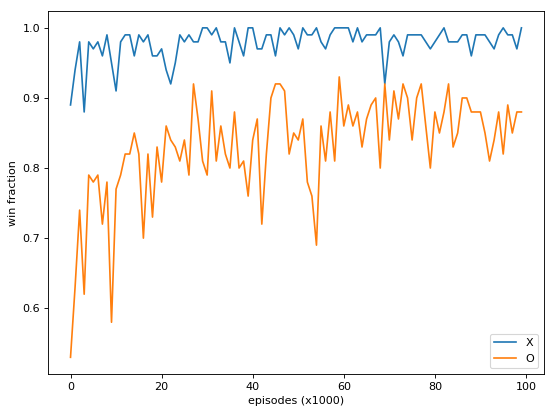

99000: results =   [100, 0, 0, 88, 12, 0] x_win_fraction = 1.000  o_win_fraction = 0.880 lr = 0.1


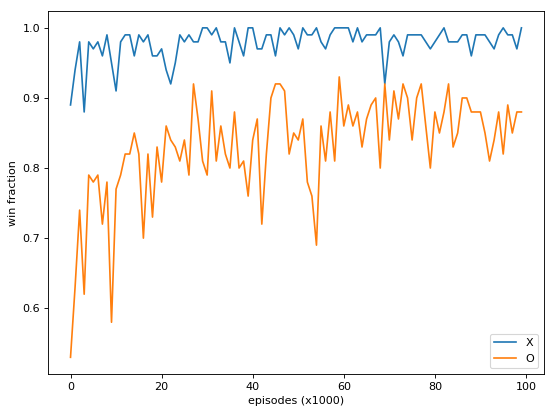

In [17]:
train_agent(ForwardAgent,skip_restore=True)

Play the agent. I've included `ForwardAgent_agent_good.h5` as a pretrained test agent.

In [32]:
play_agent(ForwardAgent)

 O|O|X
-------
 X|X|O
-------
 O|X|X

draw.


# TD Learning with Backward Looking Rewards

![backward_agent](https://adamklecz.files.wordpress.com/2017/10/null4.png)

The nice feature of the `ForwardAgent` was that you could calculate all the game moves at once in your model, taking advantange of vectorized calculations to speed things up. However, some games are too complicated to calculate in their intirety and keep in memory. This is where the `BackwardAgent` can be helpful.

This agent only considers previous moves in modifying its model. Again, `𝜆` is used to represent the weight applied to previous moves.

To implement this we simply keep a copy of our trainable variables and at each step we decay the previous value of this copy by our `𝜆` value and then add the current weights. This encapsulates the 'historical' rewards. This history is referred to as an 'eligibility trace' in RL.

You should recognize some of the pieces from the previous agents.

In [67]:
class BackwardAgent(AgentBase):
  def __init__(self,model,env,lamda = 0.7):
    super(BackwardAgent,self).__init__(model, env)
    self.opt = tf.train.AdamOptimizer()
    self.lamda = lamda

  def grad(self,inputs):
    # start gradient tape
    with tf.GradientTape() as tape:
      # calculate reward for inputs using model
      reward = self.model(inputs)
    # return the reward and the gradients based on this reward
    return reward,tape.gradient(reward, self.model.trainable_variables)

  def train(self, epsilon):
    # reset environment
    self.env.reset()
    
    # Our eligibility trace, filled with the current weights of our model
    traces = [np.zeros(tvar.shape)
              for tvar in self.model.trainable_variables]
    # current board state (empty)
    feature_vector = self.env.make_feature_vector(self.env.board)
    # current reward for board state and model gradients
    previous_value, previous_grads = self.grad(feature_vector)
    # get first reward from the environment (None)
    reward = self.env.get_reward()
    
    # run episode until a player wins
    while reward is None:
      # make a move, sometimes make a random move
      if np.random.random() < epsilon:
        self.env.make_random_move()
      else:
        move = self.get_move()
        self.env.make_move(move)
      
      # get the reward for new board state
      reward = self.env.get_reward()
      # get board feature vector
      feature_vector = self.env.make_feature_vector(self.env.board)
      
      # evaluate value function on new board
      if reward is None:
        value, grads = self.grad(feature_vector)
      else:
        value = reward
        _,grads = self.grad(feature_vector)
      
      # calculate change in reward
      delta = value - previous_value
      # scale previous trace by lamda and add new gradient
      for previous_grad, trace in zip(previous_grads, traces):
        trace *= self.lamda
        trace += previous_grad

      # update gradients for this step by the sum of the delta
      new_grads = [np.reshape(-delta * t,t.shape) for t in traces]
      # apply these gradients
      self.opt.apply_gradients(zip(new_grads, self.model.trainable_variables),
                               global_step=tf.train.get_or_create_global_step())
      # current values become new previous values
      previous_grads = grads
      previous_value = value

    return self.env.get_reward()


Now train

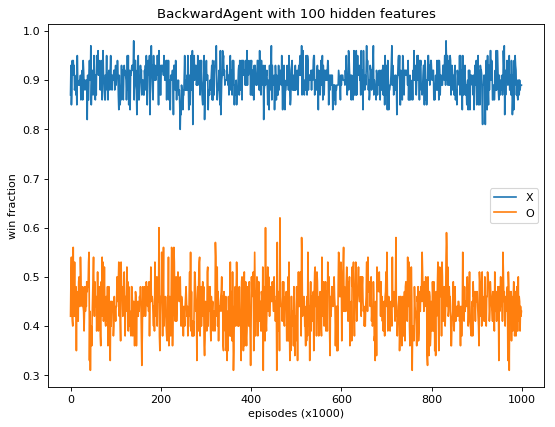

999000: results =   [89, 3, 8, 43, 24, 33] x_win_fraction = 0.890  o_win_fraction = 0.430 lr = 0.1


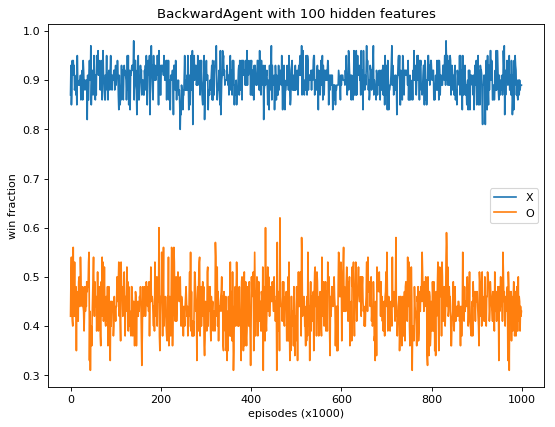

In [68]:
train_agent(BackwardAgent,1000000,model_hidden_layer_size=100,skip_restore=True,lr_period=3.0e4,lr_decay=0.5)

In [60]:
play_agent(BackwardAgent)

  | |O
-------
 O|X| 
-------
  |X| 



KeyboardInterrupt: 

# Mini-Max Pruning a Future Move Tree

![leaf_agent](https://adamklecz.files.wordpress.com/2017/10/null6.png)

In simple games it is computationally reasonable to survey the possible outcomes in some number of future moves based on the current board state.


In [70]:
# may need to run `pip install anytree` to run this
from anytree import Node
class LeafAgent(AgentBase):
  def __init__(self,model,env,lamda = 0.7):
    super(LeafAgent,self).__init__(model, env)
    self.opt = tf.train.GradientDescentOptimizer(self.lrvar)
    self.lamda = lamda

  def grad(self,inputs):
    # start gradient tape
    with tf.GradientTape() as tape:
      # calculate reward for inputs using model
      reward = self.model(inputs)
    # return the reward and the gradients based on this reward
    return reward,tape.gradient(reward, self.model.trainable_variables)

  def train(self, epsilon):
    # reset environment
    self.env.reset()

    # Our eligibility trace, filled with the current weights of our model
    traces = [np.zeros(tvar.shape) for tvar in self.model.trainable_variables]

    # current board state (empty)
    feature_vector = self.env.make_feature_vector(self.env.board)
    # current reward for board state and model gradients
    previous_leaf_value, previous_grads = self.grad(feature_vector)
    # get first reward from the environment (None)
    reward = self.env.get_reward()

    # run episode until a player wins
    while reward is None:
      # get a move, also get the reward and tree describing the move
      move, leaf_value, leaf_node = self.get_move(return_value=True)
      
      # make the move, make random moves randomly
      if np.random.rand() < epsilon:
        self.env.make_random_move()
      else:
        self.env.make_move(move)
      
      # get the updated reward
      reward = self.env.get_reward()
      # get new feature vector
      feature_vector = self.env.make_feature_vector(leaf_node.board)
      # calculate grads
      _,grads = self.grad(feature_vector)
      # update traces
      delta = leaf_value - previous_leaf_value
      for previous_grad, trace in zip(previous_grads, traces):
        trace *= self.lamda
        trace += previous_grad

      # update gradients for this step by the sum of the delta
      new_grads = [np.reshape(-delta * t,t.shape) for t in traces]
      # apply these gradients
      self.opt.apply_gradients(zip(new_grads, self.model.trainable_variables),
                               global_step=tf.train.get_or_create_global_step())

      previous_grads = grads
      previous_leaf_value = leaf_value

    return self.env.get_reward()

  def minimax(self, node, depth, alpha, beta):
    # if the current node has a result, return it
    if node.board.result() is not None:
      value = node.board.result()
      return np.array([[value]]), node
    # if reached the max depth cutoff, calculate result and return
    elif depth <= 0:
      fv = self.env.make_feature_vector(node.board)
      value = self.model(fv)
      return value, node
    
    # build nodes based on all the legal moves
    children = []
    # loop over current legal moves
    for move in node.board.legal_moves:
      # copy board
      child_board = node.board.copy()
      # make the move
      child_board.push(move)
      # create a childe node for this new board
      child = Node(str(move), parent=node, board=child_board, move=move)
      # add to list
      children.append(child)

    # take a turn
    if node.board.turn: # X-turn
      best_v = -1
      best_n = None
      # loop over child nodes
      for child in children:
        # run recursively on this child
        value, node = self.minimax(child, depth - 1, alpha, beta)
        # is this the highest valued move so far
        if value >= best_v:
          best_v = value
          best_n = node
        # alpha starts as -1, and winning == 1 for X
        alpha = max(alpha, value)
        # can stop if X is winning on this node
        if beta <= alpha:
          break
    else: # O-turn
      best_v = 1
      best_n = None
      # loop over child nodes
      for child in children:
        # run recursively on this child
        value, node = self.minimax(child, depth - 1, alpha, beta)
        # is this the lowest valued move so far
        if value <= best_v:
          best_v = value
          best_n = node
        # beta starts as 1, and winning == -1 for Y
        beta = min(beta, value)
        # can stop if Y is winning
        if beta <= alpha:
          break

    return best_v, best_n

  def get_move(self, depth=3, return_value=False):
    # create a starting node with the current board
    node = Node('root', board=self.env.board, move=None)
    # start the recursive call to minimax
    leaf_value, leaf_node = self.minimax(node, depth, -1, 1)
    # return the highest scoring move
    if len(leaf_node.path) > 1:
      move = leaf_node.path[1].move
    # otherwise return the single move

    if return_value:
      return move, leaf_value, leaf_node
    else:
      return move

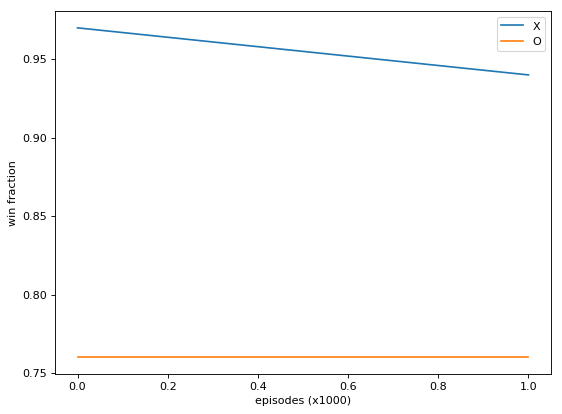

01000: results =   [94, 2, 4, 76, 14, 10] x_win_fraction = 0.940  o_win_fraction = 0.760 lr = 0.1


KeyboardInterrupt: 

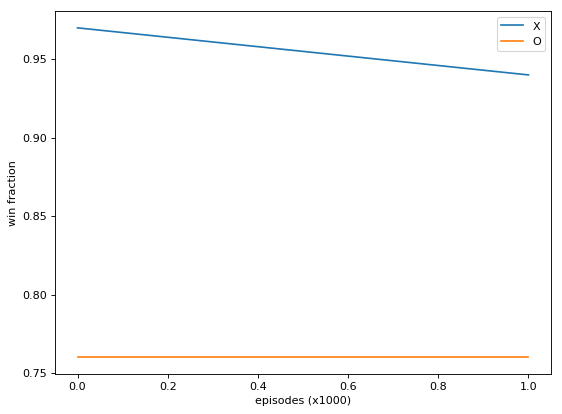

In [71]:
train_agent(LeafAgent)

# More Fun Examples for RL

Using Arcade Learning Environment
https://github.com/mgbellemare/Arcade-Learning-Environment

Open AI Gym
https://gym.openai.com/
